# Higgs Classification

By Alexander Chkodrov  
November 11th, 2019

Perform an inclusive search for the standard model Higgs boson in pp collisions at √ s = 13 TeV at the LHC using simulated data. Use a set of training datasets to optimize event selections in order to enhance the discovery sensitivity. The optimal event selections will be applied to a selected pseudo-experiment data.

In [1]:
import pickle
import math
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

#import scikit

In [2]:
infile_qcd = open("qcd_100000_pt_1000_1200.pkl", 'rb')
qcd_dict = pickle.load(infile_qcd)

infile_higgs = open("higgs_100000_pt_1000_1200.pkl", 'rb')
higgs_dict = pickle.load(infile_higgs)

In [3]:
qcd_dict.describe()

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1099.069078,0.000059,-0.004369,177.273131,0.060813,1.590390e-03,8.524137,0.004655,0.882786,0.538226,0.427151,0.609811,0.787470,0.290562
std,52.703594,0.824677,1.813312,99.972322,0.056125,3.717299e-03,8.752416,0.004442,0.171584,0.207649,0.186342,0.210203,0.122872,0.260068
min,1000.000072,-2.253943,-3.141548,11.984485,0.000710,1.819649e-07,0.086661,0.000001,0.478295,0.015832,0.012631,0.011572,0.047420,0.003521
25%,1055.360052,-0.621201,-1.579458,108.600737,0.021942,1.177585e-04,2.519231,0.001443,0.776871,0.382444,0.276735,0.462381,0.727120,0.072682
50%,1096.388294,0.001059,-0.009028,148.278900,0.041349,3.785610e-04,5.305667,0.003423,0.867831,0.548069,0.424227,0.637342,0.812622,0.207665
75%,1141.960746,0.622000,1.571494,217.478737,0.079923,1.344164e-03,11.599896,0.006412,0.955881,0.702849,0.573291,0.776890,0.876461,0.450668
max,1199.997316,2.300489,3.141578,791.955000,0.470946,9.376276e-02,507.574110,0.043964,3.994753,2.572832,1.079607,0.988677,0.991950,1.268862


In [4]:
higgs_dict.describe()

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1102.501996,-0.000017,-0.002699,126.663832,0.052299,0.000211,2.135631,0.001129,0.884533,0.288156,0.208147,0.334023,0.756502,0.260286
std,45.837988,0.549608,1.817242,8.407990,0.011856,0.000092,2.877196,0.001404,0.218984,0.161642,0.109353,0.176161,0.128856,0.100810
min,1000.012858,-1.954299,-3.141460,22.774890,0.004463,0.000002,0.309460,0.000008,0.543191,0.059126,0.044392,0.037226,0.134330,0.005540
25%,1071.301774,-0.386609,-1.577841,125.518250,0.046231,0.000142,0.891169,0.000333,0.734242,0.163427,0.131810,0.192856,0.686449,0.213529
50%,1105.070241,-0.003436,-0.004695,126.838370,0.055835,0.000191,1.269670,0.000644,0.831604,0.240890,0.178368,0.295150,0.785742,0.235491
75%,1136.769935,0.385129,1.577628,129.145697,0.060689,0.000266,2.093390,0.001313,0.968658,0.375077,0.252761,0.446858,0.852609,0.285297
max,1195.808499,1.916136,3.141587,154.613675,0.076202,0.000673,54.951194,0.033048,3.756501,1.877362,0.960652,0.978955,0.987376,0.950338


In this analysis the goal is to confirm the existance of the Higgs boson with maximum confidence. Direct observation of the Higgs is obscured by QCD background contamination, so instead observation of the parameters/features influenced by the presence of the Higgs boson will confirm discovery.

According to the Standard Model, the Higgs Boson is the quantum particle that gives particles their masses. We will use the mass of a jet as a feature to descriminate between the Higgs particles and QCD background noise. The other features we will examine later.

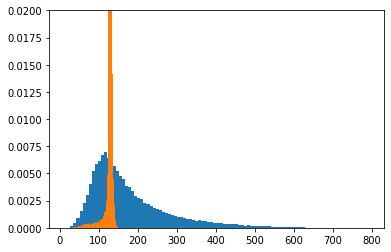

In [40]:
hist_qcd = plt.hist(qcd_dict.get('mass'), density=True, bins=100)
hist_higgs = plt.hist(higgs_dict.get('mass'), density=True, bins=100)
plt.ylim(0,0.02)
plt.show()

This is a histogram of the QCD jet mass (blue) and the Higgs jet mass (orange). The histograms are by visual inspection very different, and so would make a good candidate for a descriminatory feature.

In [132]:
tot = np.add(qcd_dict.get('mass'),higgs_dict.get('mass'))
tot.describe()

count    100000.000000
mean        303.936964
std         100.339591
min          84.995051
25%         235.304175
50%         275.338197
75%         344.612850
max         921.136313
Name: mass, dtype: float64

In [158]:
(qcd_dict.mass + higgs_dict.mass).mean()

303.9369636602252

177.27313143544927

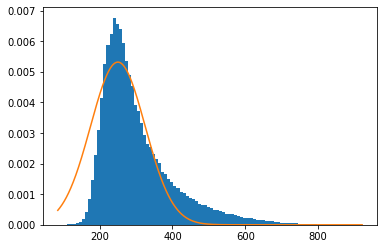

In [139]:
plt.hist(tot, density=True, bins=100)
x = np.linspace(min(tot), max(tot), len(tot))
pdf = stats.norm.pdf(x, loc=250, scale=75)
plt.plot(x, pdf)
plt.show()

This is a histogram for the distribution resulting from the addition of the Higgs and QCD mass distributions. 

Ignoring the above histogram, lets assume the Mass distributions for the QCD background and the Higgs signal are both Poisson with expected yields $N_{QCD} = 1000$ and $N_{Higgs} = 50$. Each distribution has a $\lambda = N$, where N is the given expected yield of the data set. For a poisson distribution with large $\lambda$, it can be approximated by a Gaussian distributed variable with mean $\lambda$ and standard deviation $\sqrt\lambda$.

Let $X$ be the sum of the two distributions with average $\lambda_{tot} = \lambda_{QCD}+\lambda_{Higgs}$, and is also poisson distributed. It can be approximated by a Gaussian distribution with average $\lambda_{QCD}+\lambda_{Higgs}$ and standard deviation $\sqrt{\lambda_{QCD}+\lambda_{Higgs}}$. Let $S$ be the significance. Using the Gaussian quantile function $\Phi^{-1}$, the inverse of the cumulative distribution function, we find an approximation for the expected significance 
$$S = \Phi^{-1}(1-p)$$
The p-value of the background only given an event $x$ is
$$p = 1 - \Phi({\frac{x-\mu}{\sigma}})$$
Where $\mu = \lambda_{QCD}$ and $\sigma = \sqrt{\lambda_{QCD}}$,
$$p = 1 - \Phi({\frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}})$$
Setting up for our equation for significance,
$$1-p = \Phi({\frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}})$$
$$\Phi^{-1}(1-p) = \frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}$$
Finally our value for significance,
$$S_x = \frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}$$
The average (expected) significance value of x (which has average $\lambda_{QCD}+\lambda_{Higgs}$) is
$$S_{avg} = \frac{\lambda_{Higgs}}{\sqrt{\lambda_{QCD}}}$$

By this formula, the average significance of the distribution X (the sum of the Higgs and QCD distributions) is the same as $\frac{N_{QCD}}{\sqrt{N_{QCD}}}$. Of course, this all depends on the distribution of Higgs mass and QCD mass both being Poisson distributed.

S_avg:  -inf


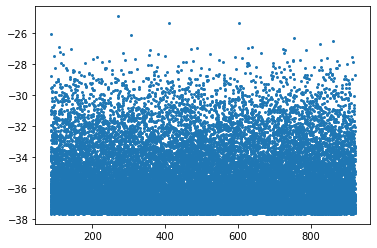

In [152]:
x = np.linspace(min(tot), max(tot), len(tot))
significance = stats.norm.ppf(stats.norm.cdf(tot, loc=2050, scale=math.sqrt(2050)))
plt.scatter(x, significance, marker=".", linewidth=.00000000001)
print('S_avg: ', significance.mean())
plt.show()

The actual data, which is not poisson distributed, does not have a 

In [144]:
significance.mean()

-26.01690796881965

In [92]:
50/math.sqrt(2000)

1.118033988749895

In [71]:
float(stats.norm.isf(float(stats.poisson.sf(100, mu=1))))

27.023236089516253

In [47]:
stats.norm.isf(stats.poisson.sf(-1, mu=1))

-inf

In [33]:
len(qcd_dict.get('mass'))

100000

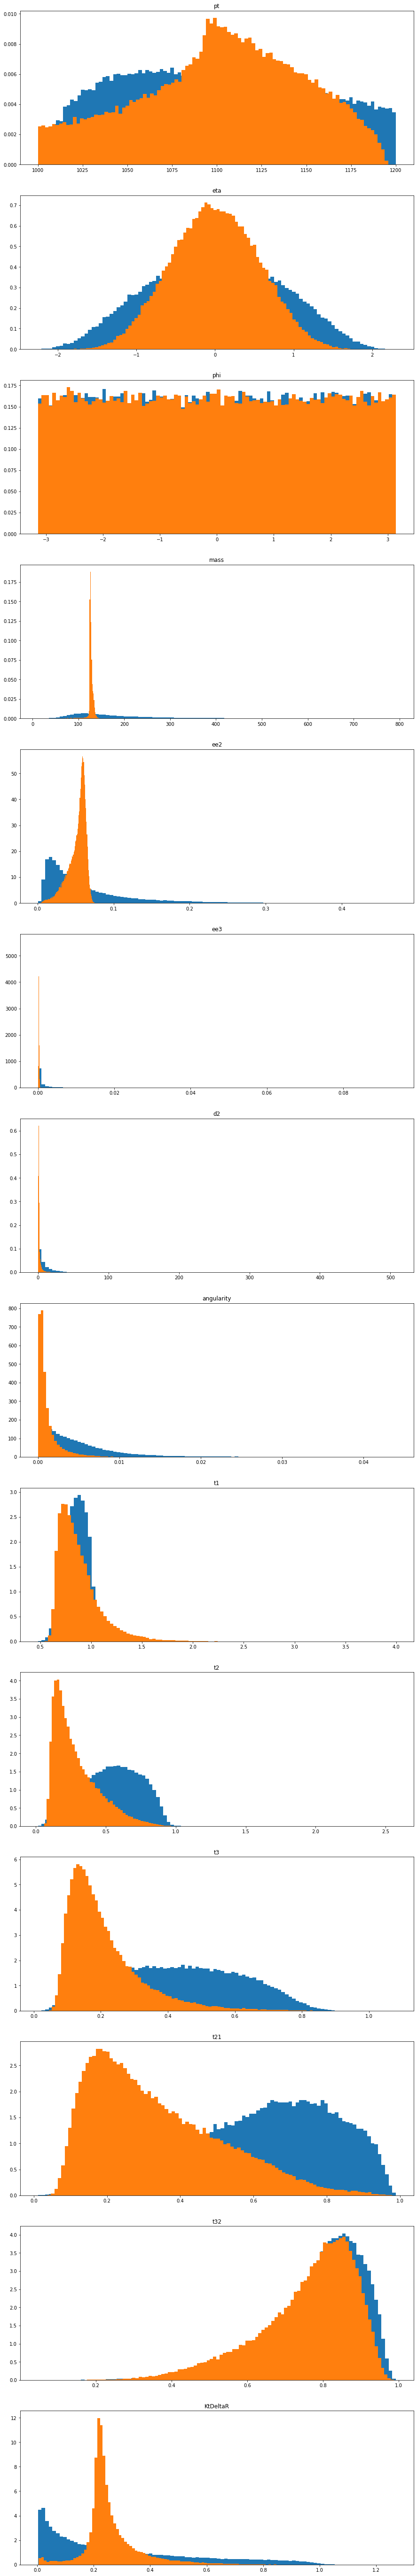

In [5]:
fig, ax_arr = plt.subplots(len(qcd_dict.keys()),1, figsize=(15,100))
index = 0
#qcd_hists = pd.DataFrame()
#higgs_hists = pd.DataFrame()
for key in qcd_dict.keys():
    ax_arr[index].hist(qcd_dict.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    ax_arr[index].hist(higgs_dict.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    index += 1

Above is a series of histograms for all features in the background data set (blue) and then for all features in the signal data set (orange). Some features, like 'phi', remain constant in both the background and signal data sets; thus the feature has no power to descriminate between background and signal. Other features, like mass, have distinctly different histograms for the background and signal data sets, and can be used to descriminate between the background and signal.

Finding the correlation of our features,

In [6]:
corr_table = qcd_dict.corr()
a = (corr_table-np.eye(len(corr_table))).max()
b = (corr_table-np.eye(len(corr_table))).idxmax()
pd.DataFrame([a,b]).T

,0,1
pt,0.0954613,mass
eta,0.00178366,phi
phi,0.00284771,t32
mass,0.959965,ee2
ee2,0.959965,mass
ee3,0.844699,ee2
d2,0.622112,t3
angularity,0.529638,mass
t1,0.326725,t2
t2,0.93664,t3


Above is a list of the maximum correlation coefficients between feautures. Mass, ee2, and ee3 are examples of highly correlated features.

In [11]:
qcd_normdat = 1/sum(dat1[0])*dat1[0]
qcd_x = np.linspace(dat1[1][0], dat1[1][-1], len(qcd_normdat))
qcd_normalized_mass_pdf = pd.DataFrame(qcd_normdat, index=qcd_x)

higgs_normdat = 1/sum(dat2[0])*dat2[0]
higgs_x = np.linspace(dat2[1][0], dat2[1][-1], len(higgs_normdat))
higgs_normalized_mass_pdf = pd.DataFrame(higgs_normdat, index=qcd_x)

plt.plot(qcd_x, qcd_normdat)
plt.show()
plt.plot(higgs_x, higgs_normdat)
plt.show()